In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join, abspath
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d

In [3]:
import sys
sys.path.insert(0, abspath("./../../"))

In [4]:
from utils.pandas import apply_filters
from utils.plt import configure_ax

from utils_local import read_spreadsheet

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Load result file

In [6]:
df = read_spreadsheet(gid_key="temporality")
df.dropna(inplace=True)

for c in set(df.columns) - {"Frames", "K400"}:
    df[c] = df[c].apply(lambda x: x.split("\u200b")[0] if isinstance(x, str) else x).astype(float)

In [7]:
df

,Frames,UCF101,SSv2,Gym99,NTU60,EPIC (V),K400,Charades
0,1,80.04,18.69,60.61,56.88,28.33,37.99,9.541
1,8,91.22,40.89,83.71,90.45,36.06,56.47,12.562
2,16,93.58,52.88,88.11,93.89,40.22,60.82,14.617
3,32,94.01,61.05,91.77,94.90,47.67,61.31,23.098


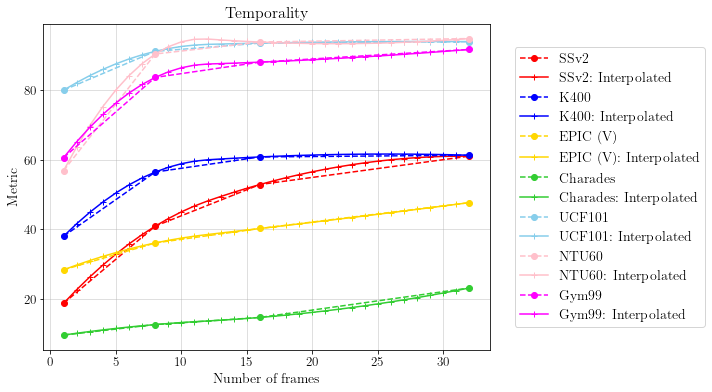

In [29]:
datasets = set(df.columns) - {"Frames"}

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.grid(alpha=0.5)

colors = ["red", "blue", "gold", "limegreen", "skyblue", "pink", "magenta"]

saturation_threshold = 1.
temporal_saturation = dict()

x = df.Frames.values
xvals = np.arange(1, np.max(x) + 1)

for i, dataset in enumerate(datasets):
    y = df[dataset].values
    
    # interpolate
    fvals = interp1d(x, y, kind="quadratic")(xvals)

    ax.plot(x, y, "o--", label=dataset, color=colors[i])
    ax.plot(xvals, fvals, "+-", color=colors[i], label=f"{dataset}: Interpolated")
    
    # compute temporal saturation
    # t: % imporvement from (t -> t + 1) < saturation_threshold (e.g., 1%)
    
    # first compute % improvement
    pct_improvement = 100 * (np.diff(fvals) / fvals[:-1])
    try:
        temporal_saturation[dataset] = next(
            t for t, v in enumerate(pct_improvement) if v < saturation_threshold
        )
    except StopIteration:
        temporal_saturation[dataset] = xvals[-1]

ax.set_title("Temporality", fontsize=16)
ax.set_xlabel("Number of frames", fontsize=14)
ax.set_ylabel("Metric", fontsize=14)

ax.tick_params(axis='y', which='major', labelsize=13, rotation=0)
ax.tick_params(axis='x', which='major', labelsize=13, rotation=0)

ax.legend(fontsize=14, bbox_to_anchor=(1.04,0.95), loc="upper left")
plt.show()

### Temporality saturation point

We define temporality saturation point $\tau$ as follows:
$$
\tau = \arg\min_{t \in {1, 2, ..., N}} \left[ 100 \times \frac{f_{t + 1} - f_{t}}{f_{t}} < \alpha \right]
$$
where $\alpha = 1.0$ is the saturation threshold. In other words, we pick number of frames $t$ s.t. the *relative improvement* is not beyond $\alpha \%$.

In [28]:
temporal_saturation

{'SSv2': 22,
 'K400': 10,
 'EPIC (V)': 32,
 'Charades': 32,
 'UCF101': 7,
 'NTU60': 9,
 'Gym99': 9}

In [9]:
x, y

(array([ 1,  8, 16, 32]), array([60.61, 83.71, 88.11, 91.77]))

In [10]:
xvals, fvals

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 array([60.61      , 65.18356383, 69.33260638, 73.05712766, 76.35712766,
        79.23260638, 81.68356383, 83.71      , 85.31191489, 86.48930851,
        87.24218085, 87.57053191, 87.69131649, 87.82148936, 87.96105053,
        88.11      , 88.26833777, 88.43606383, 88.61317819, 88.79968085,
        88.99557181, 89.20085106, 89.41551862, 89.63957447, 89.87301862,
        90.11585106, 90.36807181, 90.62968085, 90.90067819, 91.18106383,
        91.47083777, 91.77      ]))

In [14]:
pct_improvement = 100 * (np.diff(fvals) / fvals[:-1])

In [16]:
next(i for i, x in enumerate(pct_improvement) if x < 1)


9

## Junk

In [64]:
from sklearn.linear_model import TweedieRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor


In [20]:
dataset = "UCF101"

x = df.Frames.values
y = df[dataset].values

In [79]:
f = lambda x: reg.predict([[x]])

xvals = np.arange(1, 32 + 1)
fvals = [f(t) for t in xvals]

In [80]:
# fvals = np.interp(xvals, xp=x, fp=y)
fvals = interp1d(x, y, kind="quadratic")(xvals)

In [87]:
datasets

{'Charades', 'EPIC (V)', 'Gym99', 'K400', 'NTU60', 'SSv2', 'UCF101'}

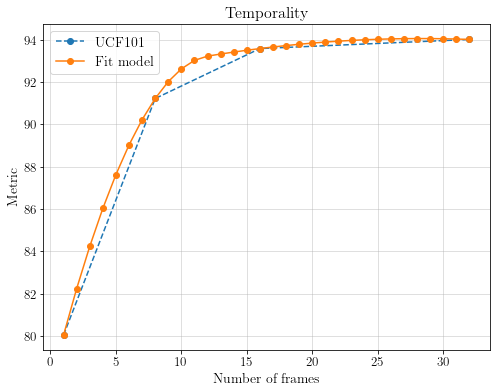

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.grid(alpha=0.5)

ax.plot(x, y, "o--", label=dataset)
ax.plot(xvals, fvals, "o-", label="Fit model")

ax.set_title("Temporality", fontsize=16)
ax.set_xlabel("Number of frames", fontsize=14)
ax.set_ylabel("Metric", fontsize=14)

ax.tick_params(axis='y', which='major', labelsize=13, rotation=0)
ax.tick_params(axis='x', which='major', labelsize=13, rotation=0)

ax.legend(fontsize=14)
plt.show()